# Persistent Monitoring and Analysis at a Corridor Scale with Lidar
## The LADDMS Persistent Dataset
Authors: William Barbour, Matthew Bunting, Derek Gloudemans, Daniel B. Work, Jonathan Sprinkle

This paper describes the persistent monitoring of a transportation corridor over the course of 120 uninterrupted days in Nashville, TN. The goal of this monitoring is to provide opportunities to design interventions for unsafe intersections, better understand traffic dynamics, and explore the potential for closed-loop control of vehicle signals and walk signs. The monitoring consisted of mounted lidar units with some overlapping, and some non-overlapping, fields of view, offering coverage of eight intersections across a span of two miles. Lidar provides a sensing modality that is becoming comparable with vision-based approaches in terms of cost. Unlike camera-based sensing, lidar is natively privacy preserving. This provides an opportunity for improved reception in communities. The paper provides a full description of the corridor, the types of classifications performed by each lidar installation, and the refresh rates and data types recorded. In addition, sample analyses are given to demonstrate the richness of the data. Sample results include hot spots for post-encroachment times between classified objects, daily turning count statistical analysis, and event heat maps such as out of crosswalk. 

Copyright (c) 2025: all software and results are copyrighted by the authors.

This project is supported through a 2022 USDOT Smart Stage I grant LADDMS awarded to the Nashville Department of Transportation. The authors are grateful for the assistance of the following project partners and collaborators led by: K. Hasan (Tennessee State University), M. Sartipi, (University of Tennessee Chattanooga), D. Hagerty (Nashville Department of Transportation, J. Turner (Metro Information Technology Services) D. Gedge (AECOM), M. Montoya (Ouster). Additional effort is supported by the National Science Foundation under Grant No. 2135579.

# Preliminaries
## Import Needed Packages

In [1]:
import psycopg as pg
from psycopg.rows import dict_row
import pickle
import csv
import json
import pandas as pd
from tabulate import tabulate

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from matplotlib.collections import LineCollection
import matplotlib.colors as mcol
import matplotlib.cm as cm
from matplotlib.dates import date2num, AutoDateLocator, ConciseDateFormatter, MinuteLocator
import plotly.express as px

import folium
import shapely as shp
import geopandas as gpd
from shapely.ops import transform
from shapely.plotting import plot_polygon, plot_line
from pyproj import Proj, Transformer
import contextily as ctx

import datetime as dt
import pytz
import zoneinfo
import numpy as np
from math import atan2, degrees, ceil
import random
import itertools
import copy
import configparser

import datetime
import pandas as pd
import os

##  Download the data
Create a folder `data/` in this drive, and download what files you would like to analyze there from the Box repository (https://vanderbilt.box.com/s/owlbxr8z2qq5y09rkr8uvdy9drhhi08l). To reproduce the plots, we recommend the following data files:
* data/location_zones.pkl (Figure 3, Figure 6)
* data/trajectories_count.csv (Figure 4)
* data/PET/20241212-2_PET.cpkl (Figure 5)
* data/raw_data/20241212-2.pkl (Figure 5)
* data/raw_data/20241016-1.pkl (Figure 3, Figure 6)


## Define common functions

In [2]:
# load a dataframe from CSV that was saved during analysis
def load_or_create_csv(filepath):
    if os.path.exists(filepath):
        try:
            df = pd.read_csv(filepath, index_col=0)
            if df.empty:
                print("CSV exists but is empty. Initializing new DataFrame.")
                return pd.DataFrame(columns=columns)
            df['day'] = pd.to_datetime(df['day'])
            print("CSV loaded successfully.")
            return df
        except Exception as e:
            print(f"Error reading CSV: {e}")
            return pd.DataFrame(columns=columns)
    else:
        print("CSV not found. Creating new DataFrame.")
        return pd.DataFrame(columns=columns)

In [3]:
def filter_vehicles(trajectory_dicts):
    filtered = []
    for t in trajectory_dicts:
        if t['classification'] in ('VEHICLE', 'LARGE_VEHICLE'):
            if t['obj_length'] + t['obj_width'] + t['obj_height'] > 6.5:
                filtered.append(t)
    return filtered

def filter_persons(trajectory_dicts):
    filtered = []
    for t in trajectory_dicts:
        if t['classification'] in ('PERSON',):
            filtered.append(t)
    return filtered


def filter_bikes(trajectory_dicts):
    filtered = []
    for t in trajectory_dicts:
        if t['classification'] in ('BICYCLE',):
            filtered.append(t)
    return filtered

def filter_distance_covered(trajectory_dicts, distance_threshold):
    filtered = []
    for t in trajectory_dicts:
        if len(t['utm_x']) >= 2:
            if ((t['utm_x'][0] - t['utm_x'][-1]) ** 2 + (t['utm_y'][0] - t['utm_y'][-1]) ** 2) ** 0.5 >= distance_threshold:
                filtered.append(t)
    return filtered

def trajectories_to_linestrings(trajectories):
    return [shp.geometry.LineString([(x, y) for x, y in zip(traj['utm_x'], traj['utm_y'])]) 
            for traj in trajectories]

# Figure 3: Trajectories on a single intersection across one day, all modes of travel, for October 16, 2024

In [4]:
# generate a file for the zones to be reread later
with open('data/location_zones.pkl', 'rb') as f:
    zones = pickle.load(f)

In [5]:
# load the trajectory data
with open('data/raw_data/20241016-1.pkl', 'rb') as f:
    data = pickle.load(f)

In [6]:
len(data)

27049

In [7]:
print(f"Total trajectories: {len(data)}")
people = filter_distance_covered(filter_persons(data), distance_threshold=10)
bikes = filter_distance_covered(filter_bikes(data), distance_threshold=12)
vehicles = filter_distance_covered(filter_vehicles(data), distance_threshold=12)
print(f"Total persons, distance filtered: {len(people)}")
print(f"Total bikes, distance filtered: {len(bikes)}")
print(f"Total vehicles, distance filtered: {len(vehicles)}")


Total trajectories: 27049
Total persons, distance filtered: 894
Total bikes, distance filtered: 58
Total vehicles, distance filtered: 18848


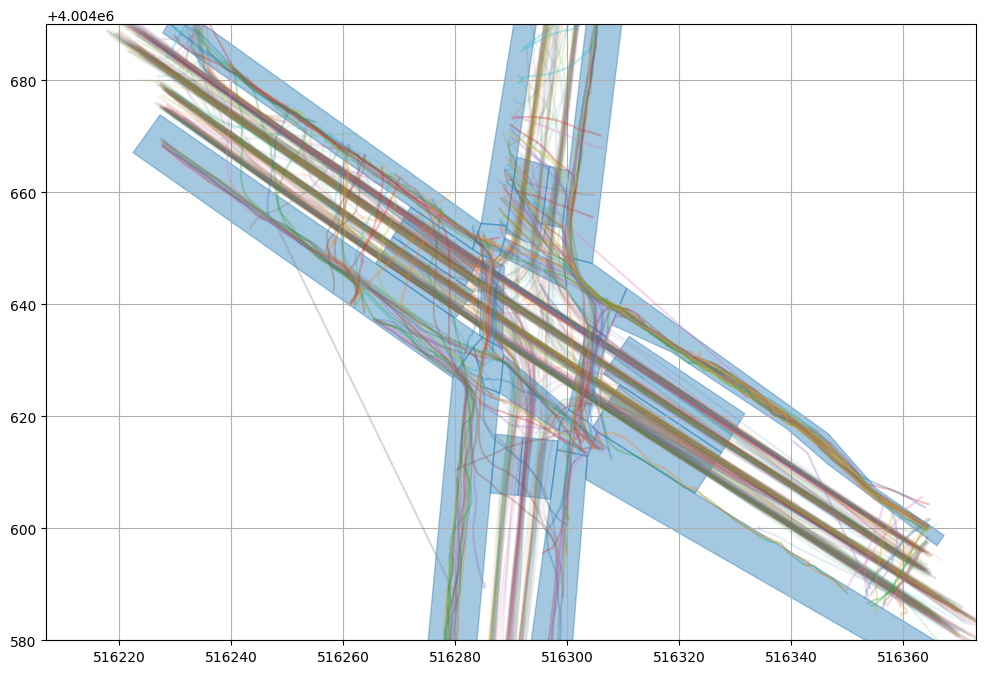

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot zones for overlay
for pid, z in zones.items():
    if z['install_id'] == 1:
        plot_polygon(z['geom'], add_points=False, alpha=0.4)

# Plot every 25th vehicle
for traj in vehicles[::25]:
    plt.plot(traj['utm_x'][::10], traj['utm_y'][::10], alpha=0.12)
# Plot every fifth pedestrian
for traj in people[::5]:
    plt.plot(traj['utm_x'][::10], traj['utm_y'][::10], alpha=0.3)
    
plt.axis('equal')
plt.xlim((516240, 516340))
plt.ylim((4004580, 4004690))
plt.savefig("Figure3_ex_trajectories_26th_20241016.png", transparent=True, bbox_inches='tight')
plt.show()

# Figure 4: data from throughout the duration of persistent monitoring
In this figure, all filtered vehicle counts across 120 days, with distribution across weekdays are presented. Days where an intersection was offline are removed as outliers for plotting. Boxplots display interquartile ranges for each value; outliers more than 1.5 times the interquartile range are shown by circles

In [9]:
df = load_or_create_csv('data/trajectories_count.csv')

cols_to_check = ['total_trajectories']
df = df[~(df[cols_to_check] == 0).any(axis=1)]

CSV loaded successfully.


Look at the dataframe, which includes information for each day (stamped with the start time of each day as a datetime value in Central Time), the location of the intersection, total trajectories observed, and then the filtered vehicles, bikes, and persons on that day. 

In [10]:
df

day  location  total_trajectories  \
0   2024-09-01 00:00:01-05:00         1               16875   
1   2024-09-01 00:00:01-05:00         2               24470   
2   2024-09-01 00:00:01-05:00         3               38097   
3   2024-09-01 00:00:01-05:00         4               13788   
4   2024-09-01 00:00:01-05:00         5               34598   
..                        ...       ...                 ...   
955 2024-12-29 00:00:01-05:00         4               17900   
956 2024-12-29 00:00:01-05:00         5               37661   
957 2024-12-29 00:00:01-05:00         6               37083   
958 2024-12-29 00:00:01-05:00         7               11290   
959 2024-12-29 00:00:01-05:00         8               11902   

     vehicles_filtered  bikes_filtered  persons_filtered  
0                13027              90               691  
1                11547             118               879  
2                12593             120               478  
3                 9748              91               194  
4                10785             120               514  
..                 ...             ...               ...  
955               8575              33               174  
956              11017              71               888  
957              12824              96              1912  
958               6231              35               425  
959               7947              28               220  

[954 rows x 6 columns]

## Plot data by intersection, and by day

In [11]:
#define the days of the week
days = ['Mondays','Tuesdays','Wednesdays','Thursdays','Fridays','Saturdays','Sundays']
# Add a column for weekday name (e.g., 'Monday')
df['weekday'] = df['day'].dt.day_name()

Define function to plot by day

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_weekday_boxplots(
    df,
    value_col: str,
    group_col: str = 'location',
    weekday_col: str = 'weekday',
    title: str = None,
    ylabel: str = None,
    figsize=(12, 5),
    cmap=plt.cm.tab10,
    figname='all_vehicles.png'
):
    # Ensure weekday column exists and is ordered
    if weekday_col not in df.columns:
        df['day'] = pd.to_datetime(df['day'])
        df[weekday_col] = df['day'].dt.day_name()
    
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df[weekday_col] = pd.Categorical(df[weekday_col], categories=weekday_order, ordered=True)

    # Prepare plotting
    plt.figure(figsize=figsize)
    group_keys = sorted(df[group_col].unique())
    colors = cmap.colors[:len(group_keys)]
    offsets = pd.Series(range(len(group_keys))) - (len(group_keys) - 1) / 2
    offsets *= 0.2  # spacing

    # weekday_positions = {day: i+1 for i, day in enumerate(weekday_order)}
    weekday_positions = {day: i*2+1 for i, day in enumerate(weekday_order)}
    for key, color, offset in zip(group_keys, colors, offsets):
        data = [
            df[(df[weekday_col] == day) & (df[group_col] == key)][value_col]
            for day in weekday_order
        ]
        plt.boxplot(
            data,
            positions=[p + offset for p in weekday_positions.values()],
            widths=0.2,
            patch_artist=True,
            boxprops=dict(facecolor=color, alpha=0.6),
            medianprops=dict(color='black'),
            tick_labels=weekday_order if offset == 0 else ['' for _ in weekday_order]
        )

    # Labels and styling
    plt.title(title or f'{value_col} by Weekday, Grouped by {group_col}')
    # plt.xlabel('Weekday')
    plt.ylabel(ylabel or value_col)
    plt.xticks(ticks=list(weekday_positions.values()), labels=weekday_order, rotation=0)
    # plt.legend([f"Loc: {key}" for key in group_keys], loc='upper right')
    
    import matplotlib.patches as mpatches

    handles = [
        mpatches.Patch(color=color, label=f"{group_col}: {key}")
        for key, color in zip(group_keys, colors)
    ]
    plt.legend(handles=handles, loc='upper right',bbox_to_anchor=(1.15, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(figname, dpi=300, bbox_inches='tight')
    plt.show()

## Show for Vehicles

Call the boxplot function for `vehicles_filtered` to reproduce Figure 4.

In [13]:

plot_weekday_boxplots(df, 'vehicles_filtered', title=f'Filtered Vehicle Counts by Weekday, Grouped by Intersection',
                     ylabel='Vehicle Count (filtered)',figname='Figure4_all_vehicles.png')

## Additional Plot: Bicycle
Additional plots not included in the pape are given below.

In [14]:
plot_weekday_boxplots(df, 'bikes_filtered', title=f'Filtered Bicycle Counts by Weekday, Grouped by Intersection',
                     ylabel='Bicycle Count (filtered)',figname='all_bicycles.png')

## Additional Plot: Persons

In [15]:
plot_weekday_boxplots(df, 'persons_filtered', title=f'Filtered Person Counts by Weekday, Grouped by Intersection',
                     ylabel='Person Count (filtered)',figname='all_persons.png')

# Figure 5: Post Encroachment Time (PET) for a representative day (December 12, 2024)

This section loads data from a different day and location: Location 2, on December 12, 2024. One reason to load a different day and location is to provide different examples. Loading a different file will produce variations in plots.

In [16]:
all_events = []

with open('data/PET/20241212-2_PET.cpkl', 'rb') as f:
    events = pickle.load(f)
    all_events += events

# load other events and append them as desired to all_events
    
with open('data/raw_data/20241212-2.pkl', 'rb') as f:
    data = pickle.load(f)

In [17]:
# uncomment to see what all_events is comprised of
# all_events

In [18]:
# Lookup dictionary for raw trajectories so that they can join with PET events
data_keyed = {d['object_id']: d for d in data}

In [19]:
def get_speed_at_time(trajectory, time_value, smooth_vals=4):
    ts_i = np.argmin([abs((tsv - time_value).total_seconds()) for tsv in trajectory['ts']])
    i1 = max(0, ts_i - smooth_vals)
    i2 = min(len(trajectory['ts']) - 1, ts_i + smooth_vals)
    del_t = (trajectory['ts'][i2] - trajectory['ts'][i1]) 
    vx = (trajectory['obj_x'][i2] - trajectory['obj_x'][i1])
    vy = (trajectory['obj_y'][i2] - trajectory['obj_y'][i1])
    vel = (vx**2 + vy**2) ** 0.5
    return vel

In [20]:
# Filter PET events based on speed at the event

filtered_events = []
for e in all_events:
    v1 = get_speed_at_time(data_keyed[e['id1']], e['t1'])
    v2 = get_speed_at_time(data_keyed[e['id2']], e['t2'])
    if v1 < 3 or v2 < 3:
        continue
    else:
        filtered_events.append({'v1': v1, 'v2': v2, **e})
print(f"Filtered from {len(all_events)} to {len(filtered_events)} events.")

Filtered from 4201 to 1608 events.


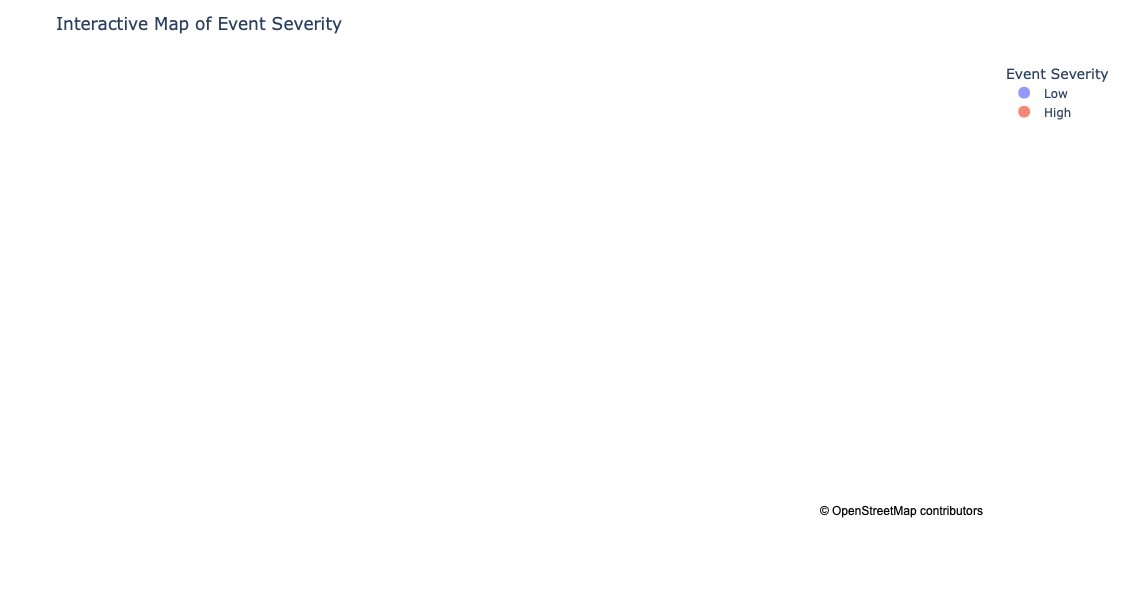

In [21]:
# Step 1: Convert data into DataFrame
df = pd.DataFrame(filtered_events)

# Separate the location into X and Y (assuming projected CRS)
df[['X', 'Y']] = pd.DataFrame(df['location'].tolist(), index=df.index)

# Step 2: Classify severity
def classify_severity(row):
    if row['cls1'] == 'PERSON' and row['t1'] < row['t2']:
        return 'High'
    elif row['cls2'] == 'PERSON' and row['t2'] < row['t1']:
        return 'High'
    else:
        return 'Low'

df['severity'] = df.apply(classify_severity, axis=1)

# Step 3: Filter events involving PERSON
df = df[(df['cls1'] == 'PERSON') | (df['cls2'] == 'PERSON')]

# Step 4: Non-linear scaling of PET for marker size
# Use inverse square root scaling as an example
max_size = 20
df['marker_size'] = df['PET'].apply(lambda x: max_size / np.sqrt(12*x+1))
df.loc[df['severity'] == 'Low', 'marker_size'] /= 2

# Step 5: Convert coordinates to Latitude and Longitude
# Assuming data is in UTM Zone 16N as an example, convert accordingly
from pyproj import Transformer

transformer = Transformer.from_crs("epsg:26916", "epsg:4326", always_xy=True)
df['lon'], df['lat'] = transformer.transform(df['X'].values, df['Y'].values)

# Step 6: Interactive Plot with Plotly Express
fig = px.scatter_mapbox(
    df,
    lat='lat',
    lon='lon',
    hover_name='severity',
    hover_data={
        'cls1': True,
        'cls2': True,
        't1': False,
        't2': False,
        'PET': ':.2f',
        'intersection': False,
        'v1': ':.1f',
        'v2': ':.1f',
    },
    color='severity',
    size='marker_size',
    size_max=max_size,  # Ensure size_max matches upper limit of clip
    zoom=16,
    height=600,
    mapbox_style='open-street-map',
)

# fig.update_traces(
#     marker=dict(
#         symbol=df['severity'].apply(lambda x: 'triangle-up' if x == 'High' else 'circle'),
#         sizemode='area',
#         opacity=0.8,
#         line=dict(width=1, color='black'),
#     )
# )

fig.update_layout(
    title='Interactive Map of Event Severity',
    legend_title_text='Event Severity',
)

fig.show()
fig.write_html('Figure5-near-miss.html')

# Figure 6: Pedestrian trajectories that contain out-of-crosswalk segments greater than 10m in length, taken from 26th/Clarksville (location 1) on October 16, 2024.

This figure describes when pedestrians cross in zones not defined as pedestrian zones, in location 1. The figure will only be generated if the data are reloaded, since earlier in the notebook we loaded data from a different day.

In [22]:
with open('data/raw_data/20241016-1.pkl', 'rb') as f:
    data = pickle.load(f)

Define a new function for use in plotting 

In [23]:
from shapely.ops import unary_union

def lines_with_external_segments(lines, polygons, min_length=5):
    """
    Filters a list of LineStrings, returning only those that have at least one segment 
    outside the union of a set of polygons, and that segment is longer than a specified minimum length.

    Parameters:
    -----------
    lines : list of shapely.geometry.LineString
        A list of LineString geometries to be tested for external segments.

    polygons : list of shapely.geometry.Polygon
        A list of Polygon geometries whose union defines the "interior" region.

    min_length : float, optional (default=5)
        The minimum length a line segment must have (outside the polygon union) 
        to be considered valid.

    Returns:
    --------
    list of shapely.geometry.LineString
        A list of LineStrings for which at least one external segment 
        (outside the polygon union) is longer than `min_length`.

    Notes:
    ------
    - If a LineString is entirely inside the polygon union or its only 
      external segments are shorter than `min_length`, it is excluded.
    - Multi-part geometries resulting from the `.difference()` operation 
      are correctly handled.
    """
    polygon_union = unary_union(polygons)
    result = []

    for line in lines:
        difference = line.difference(polygon_union)

        if difference.is_empty:
            continue

        # Handle both single and multi-segment cases
        segments = [difference] if difference.geom_type == 'LineString' else list(difference.geoms)

        for seg in segments:
            if seg.length >= min_length:
                result.append(line)
                break  # Only need one valid segment
    return result

In [24]:
# plot only lines that have segments outside the pedestrian zones for this location
outside_lines = lines_with_external_segments(trajectories_to_linestrings(people), 
                                             [z['geom'] for z in zones.values() if z['install_id'] == 1],
                                             min_length=10)

Inside of zone 1, the following zones define the direction of travel for vehicles and pedestrians.

In [25]:
veh_movement_keys = {
    '26th_nb_th': (72, 71),
    '26th_nb_lt': (72, 67),
    '26th_nb_rt': (72, 69),
    '26th_sb_th': (70, 73),
    '26th_sb_lt': (70, 69),
    '26th_sb_rt': (70, 67),
    'Clarksville_wb_th': (68, 67),
    'Clarksville_wb_rt': (68, 71),
    'Clarksville_wb_lt': (68, 73),
    'Clarksville_eb_th': (66, 69),
    'Clarksville_eb_rt': (66, 73),
    'Clarksville_eb_lt': (66, 71),
}
print(veh_movement_keys)
veh_zones = [72, 71, 67, 69, 70, 73, 67, 68, 66]
ped_zones = [1, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]

{'26th_nb_th': (72, 71), '26th_nb_lt': (72, 67), '26th_nb_rt': (72, 69), '26th_sb_th': (70, 73), '26th_sb_lt': (70, 69), '26th_sb_rt': (70, 67), 'Clarksville_wb_th': (68, 67), 'Clarksville_wb_rt': (68, 71), 'Clarksville_wb_lt': (68, 73), 'Clarksville_eb_th': (66, 69), 'Clarksville_eb_rt': (66, 73), 'Clarksville_eb_lt': (66, 71)}


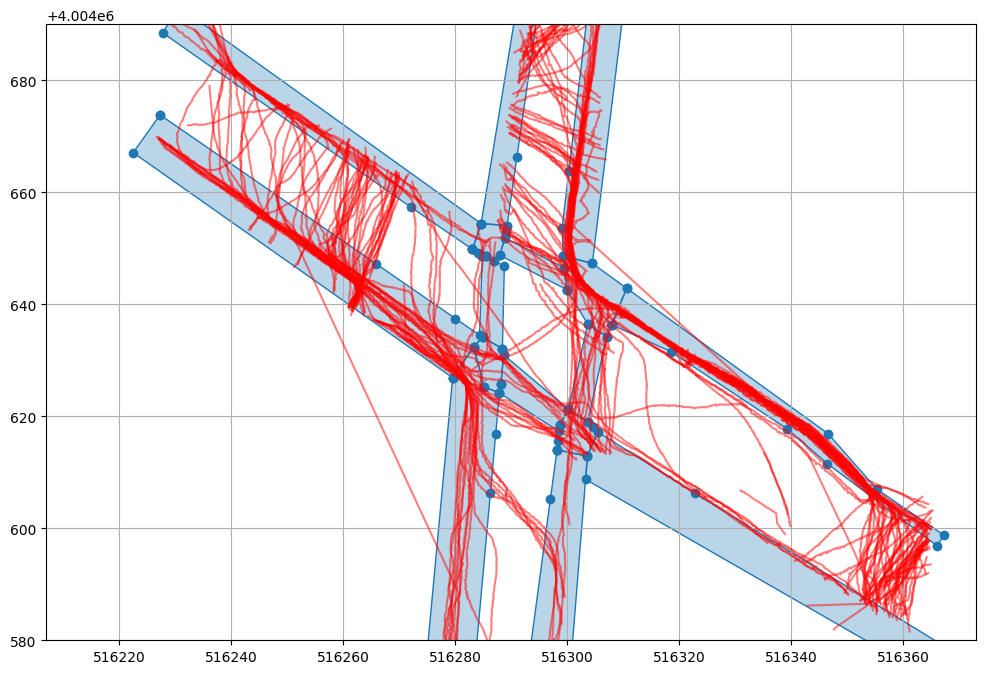

In [26]:
# plot the results

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot zones for overlay
for pid, z in zones.items():
    if z['install_id'] == 1 and pid in ped_zones:
        plot_polygon(z['geom'])

# Plot every fifth pedestrian
for traj in outside_lines:
    plt.plot(traj.xy[0], traj.xy[1], c='r', alpha=0.5)
    
plt.axis('equal')
plt.xlim((516240, 516340))
plt.ylim((4004580, 4004690))
plt.savefig("Figure6_ped_ooc_26th_20241016.png", transparent=True, bbox_inches='tight')
plt.show()